In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append("../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1

In [4]:
# # generate some training data
n_samples = 220
seq_len = 18

## generate sin wave data with different frequencies
def generate_sin_wave_data(n_samples, seq_len, noise=0.1, seed=42):
    np.random.seed(seed)
    X = []
    y = []
    for i in range(n_samples):
        freq = np.random.uniform(0.1, 1.0)  # frequency between 0.1 and 1.0
        x = np.linspace(0, 6 * np.pi, seq_len)
        seq = np.sin(freq * x) + np.random.normal(0, noise, seq_len)  # add some noise
        X.append(seq)
        y.append(freq)  # target is the frequency
    X = np.array(X).reshape(n_samples, seq_len, 1)  # shape (n_samples, seq_len, 1)
    y = np.array(y).reshape(n_samples, 1)  # shape (n_samples, 1)
    return X, y

X, y_true = generate_sin_wave_data(n_samples, seq_len, noise=0.05)
# normalize X to [0, 1]
X = (X - X.min()) / (X.max() - X.min())
print(f"Generated data shapes: {X.shape}, {y_true.shape}")

Generated data shapes: (220, 18, 1), (220, 1)


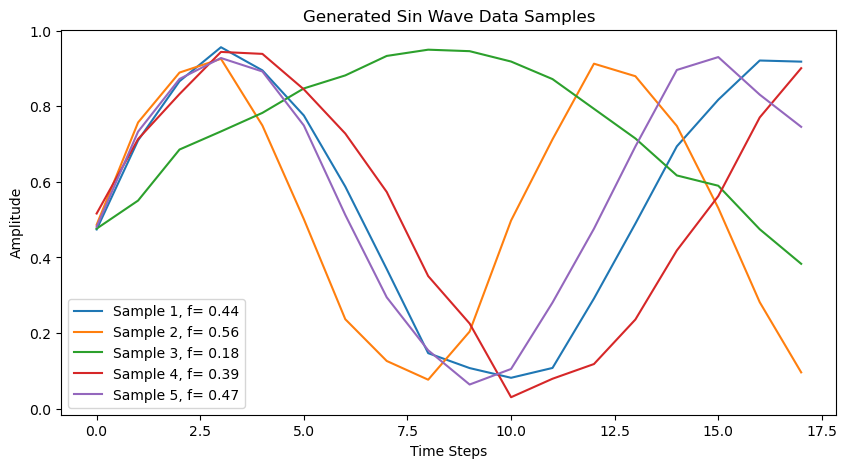

In [5]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X[i].flatten(), label=f"Sample {i+1}, f= {y_true[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [6]:
# train test split
percentage = 0.8
X_train, X_test, y_train, y_test = train_test_split(
    X, y_true, test_size=1 - percentage, random_state=42
)

In [30]:
seq_len = X_train.shape[1]
hparams = {
    "n_features": (n_features := 5),
    "sampling_rate": 0.2,
    "protocol": "min-delay",
    "n_ancilliary_qubits": (n_ancilliary_qubits := 0),
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
}

sep = 6.8
parameters = {
    # separation of 7 between the qubits
    "positions": [[sep * i - (sep * 2), 0] for i in range(n_features)],
    "local_pulses_omega_1": [0.2, 1.0, 1.5, 1.0, 0.2],
    "local_pulses_delta_1": [0.0] * n_features,
    "global_pulse_omega_1": 0.5,
    "global_pulse_delta_1": 0.0,
    "global_pulse_omega_2": 0.5,
    "global_pulse_delta_2": 0.0,
    "global_pulse_duration": 100,
    "local_pulse_duration": 80,
    "embed_pulse_duration": 80,
}


NAHEA_CNN = NAHEA_CNN_1(
    hparams=hparams, parameters=parameters, name="NAHEA_CNN_2"
)
NAHEA_CNN.eval()

Final FC NN: Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
  (5): ReLU()
)
Adding parameter 0.weight to model
Adding parameter 0.bias to model
Adding parameter 2.weight to model
Adding parameter 2.bias to model
Adding parameter 4.weight to model
Adding parameter 4.bias to model


In [31]:
# look at kernel outputs
from source.NAHEA_CNN import state_to_output_learned

NAHEA_CNN.eval()
y_pred_test = []
i = 0
x_tmp = X_test[i]
x_tmp = torch.tensor(x_tmp, dtype=torch.float64).squeeze(1)
out_tmp = []
results_tmp = []
xs_slice = []
for pos in tqdm(range(0, seq_len - n_features + 1, NAHEA_CNN.hparams["stride"])):
    base_seq = NAHEA_CNN.setup_register()
    x_slice = x_tmp[pos : pos + n_features]
    seq_built = base_seq.build(x=x_slice)
    sim = TorchEmulator.from_sequence(seq_built, sampling_rate=0.2)

    with torch.no_grad():
        results = sim.run(
            time_grad=False, dist_grad=False, solver=SolverType.DP5_SE
        )
    output = state_to_output_learned(
        results.states[-1], NAHEA_CNN.classical_params["conv_params"]
    ).squeeze()
    out_tmp.append(output.item())
    results_tmp.append(results)
    xs_slice.append(x_slice.numpy())

  0%|          | 0/5 [00:00<?, ?it/s]

In [32]:
print(f"{results.states[-1].abs()=}")
print(f"{NAHEA_CNN.classical_params['conv_params']=}")

results.states[-1].abs()=tensor([[0.0008],
        [0.0472],
        [0.0139],
        [0.0331],
        [0.0351],
        [0.1798],
        [0.0032],
        [0.0510],
        [0.0157],
        [0.0903],
        [0.0564],
        [0.0845],
        [0.0077],
        [0.1790],
        [0.2433],
        [0.3292],
        [0.0502],
        [0.0729],
        [0.0667],
        [0.1330],
        [0.2113],
        [0.2768],
        [0.1995],
        [0.3841],
        [0.0351],
        [0.1237],
        [0.1196],
        [0.0545],
        [0.0662],
        [0.3299],
        [0.2641],
        [0.4320]], dtype=torch.float64)
NAHEA_CNN.classical_params['conv_params']=tensor([ 0.0685,  0.0296,  0.0140,  0.0437,  0.0346,  0.0740,  0.0349,  0.0364,
        -0.0054,  0.0062,  0.0539,  0.0415,  0.0468,  0.0341,  0.0506,  0.0548,
         0.0468,  0.0631,  0.0470,  0.0145,  0.0278,  0.0144,  0.0365,  0.0519,
         0.0223,  0.0670,  0.0211,  0.0204,  0.0441,  0.0335,  0.0783,  0.0404],
       dtype=t

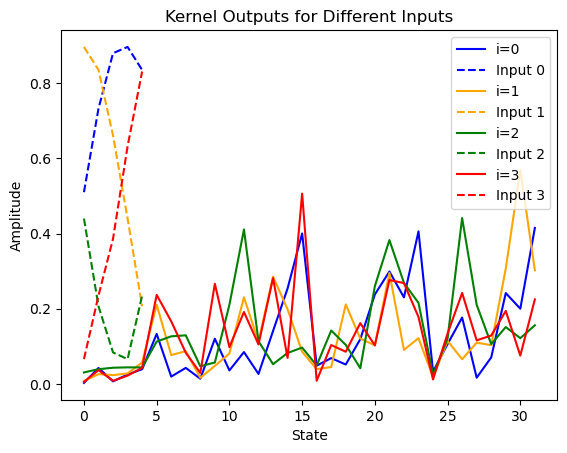

In [33]:
colors = ["blue", "orange", "green", "red"]
for i in range(4):
    plt.plot(results_tmp[i].states[-1].abs().numpy(), label=f"{i=}", c=colors[i])
    plt.plot(xs_slice[i], label=f"Input {i}", linestyle='--', c=colors[i])
    plt.title("Kernel Outputs for Different Inputs")
    plt.xlabel("State")
    plt.ylabel("Amplitude")
    plt.legend()
plt.show()

In [19]:
# check normalization
out_states = results_tmp[0].states[-1].abs().numpy()
np.sum(out_states)  # should be close to 1

4.472076160328342

In [ ]:
# train the model
batch_size = 16
epochs = 20
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
NAHEA_CNN.train()
print(f"{NAHEA_CNN.parameters()}")
optimizer = torch.optim.Adam(
    [param for _, param in NAHEA_CNN.parameters().items() if param.requires_grad],
)
params_hist = [copy.deepcopy(NAHEA_CNN.parameters())]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64)
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = [NAHEA_CNN(xx) for xx in x_batch]
        predicted = torch.stack([bo["output"] for bo in batch_out])
        loss = loss_fn(predicted.squeeze(1), y_batch)
        tqdm.write(
            f"Batch {i // batch_size + 1}/{n_samples // batch_size}, Loss: {loss.item()}"
        )
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append(copy.deepcopy(NAHEA_CNN.parameters()))
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss: {loss_hist[-1]}")

{'positions': tensor([[-13.6000,   0.0000],
        [ -6.8000,   0.0000],
        [  0.0000,   0.0000],
        [  6.8000,   0.0000],
        [ 13.6000,   0.0000]], requires_grad=True), 'local_pulses_omega_1': tensor([0.5000, 1.0000, 1.5000, 1.0000, 0.5000], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.], requires_grad=True), 'global_pulse_omega_1': tensor(1., requires_grad=True), 'global_pulse_delta_1': tensor(0., requires_grad=True), 'global_pulse_omega_2': tensor(0.5000, requires_grad=True), 'global_pulse_delta_2': tensor(0., requires_grad=True), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([ 0.0280,  0.0528,  0.0220,  0.0497,  0.0476,  0.0437,  0.0268,  0.0404,
         0.0581,  0.0392,  0.0923,  0.0564,  0.0446,  0.0125,  0.0377,  0.0462,
         0.0589,  0.0459,  0.0388,  0.0247,  0.0379,  0.0018, -0.0033,  0.0471,
         0.0364,  0.0558,  0.0244,  0.0217,  0.028

Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.33727770812381985
Batch 2/13, Loss: 0.31754891394262963
Batch 3/13, Loss: 0.36061040073024453
Batch 4/13, Loss: 0.3768990063391957
Batch 5/13, Loss: 0.3693383927122781
Batch 6/13, Loss: 0.42008354245244217
Batch 7/13, Loss: 0.34778848444989474
Batch 8/13, Loss: 0.31696218158237394
Batch 9/13, Loss: 0.21775504196289402
Batch 10/13, Loss: 0.2720749663066768
Batch 11/13, Loss: 0.3077248691462483
Epoch 1 train loss: 0.33127850070442705


Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.2892814336498324
Batch 2/13, Loss: 0.2719718825307292
Batch 3/13, Loss: 0.30865107719210155
Batch 4/13, Loss: 0.3200532099362327
Batch 5/13, Loss: 0.3129979477042114
Batch 6/13, Loss: 0.3601598393125408
Batch 7/13, Loss: 0.29470559168586286
Batch 8/13, Loss: 0.26629794065087115
Batch 9/13, Loss: 0.17737188004794263
Batch 10/13, Loss: 0.22708825997870796
Batch 11/13, Loss: 0.26014946223136237
Epoch 2 train loss: 0.28079350226549044


Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.2453654996660518
Batch 2/13, Loss: 0.22797466879961703
Batch 3/13, Loss: 0.2599545579947656
Batch 4/13, Loss: 0.2692329782086308
Batch 5/13, Loss: 0.2625888505243009
Batch 6/13, Loss: 0.30647664920600526
Batch 7/13, Loss: 0.2457309329277073
Batch 8/13, Loss: 0.21830717898678736
Batch 9/13, Loss: 0.14030655343576848
Batch 10/13, Loss: 0.18395966502904904
Batch 11/13, Loss: 0.2117660079247065
Epoch 3 train loss: 0.2337875947912173


Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.20165935553912265
Batch 2/13, Loss: 0.18473330535552684
Batch 3/13, Loss: 0.20939563413357717
Batch 4/13, Loss: 0.21433049250101321
Batch 5/13, Loss: 0.20773088405106532
Batch 6/13, Loss: 0.24526742834328857
Batch 7/13, Loss: 0.1928342941305391
Batch 8/13, Loss: 0.16830938353008157
Batch 9/13, Loss: 0.10312094080127758
Batch 10/13, Loss: 0.139466506069492
Batch 11/13, Loss: 0.16250234821322287
Epoch 4 train loss: 0.18448641569710975


Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.157573843680469
Batch 2/13, Loss: 0.14212249378578823
Batch 3/13, Loss: 0.159214014360158
Batch 4/13, Loss: 0.1592628539285434
Batch 5/13, Loss: 0.1518202308095523
Batch 6/13, Loss: 0.18413523460292242
Batch 7/13, Loss: 0.14378965737384464
Batch 8/13, Loss: 0.12012833565399603
Batch 9/13, Loss: 0.07195169783395745
Batch 10/13, Loss: 0.10067353549686638
Batch 11/13, Loss: 0.11796052714001304
Epoch 5 train loss: 0.1371484022423737


Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

Batch 1/13, Loss: 0.1196863237091918
Batch 2/13, Loss: 0.10635388190130618
Batch 3/13, Loss: 0.11577361240514182
Batch 4/13, Loss: 0.11020631772520942
Batch 5/13, Loss: 0.10484586357757444
Batch 6/13, Loss: 0.13092130446634517
Batch 7/13, Loss: 0.10220471828618315


In [ ]:
# test the model
NAHEA_CNN.eval()
y_pred_test = []
for i in range(len(X_test)):
    x_test = torch.tensor(X_test[i], dtype=torch.float64)
    pred = NAHEA_CNN(x_test)["output"].item()
    y_pred_test.append(pred)
y_pred_test = torch.tensor(y_pred_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
loss_test = loss_fn(y_pred_test, y_test)
print(f"Test loss MSE: {loss_test.item()}")
print(f"RMSE: {torch.sqrt(loss_test).item()}")
print("final parameters:")
print(NAHEA_CNN.parameters())

Test loss MSE: 0.06630647485290996
RMSE: 0.257500436607222
final parameters:
{'positions': tensor([[-14.0435,   0.0000],
        [ -7.0611,   0.0000],
        [  0.0817,   0.0000],
        [  6.9848,   0.0000],
        [ 14.0626,   0.0000]], requires_grad=True), 'local_pulses_omega_1': tensor([0.4559, 0.9435, 1.5820, 1.0733, 0.5668], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0., 0.], requires_grad=True), 'global_pulse_omega_1': tensor(1.0729, requires_grad=True), 'global_pulse_delta_1': tensor(0., requires_grad=True), 'global_pulse_omega_2': tensor(0.5822, requires_grad=True), 'global_pulse_delta_2': tensor(0., requires_grad=True), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([0.0821, 0.0990, 0.1343, 0.1090, 0.1470, 0.0977, 0.0797, 0.1121, 0.1212,
        0.0912, 0.1378, 0.1210, 0.0985, 0.1259, 0.0956, 0.0762, 0.0961, 0.1370,
        0.1383, 0.0936, 0.1244, 0.1077, 0.1422, 0

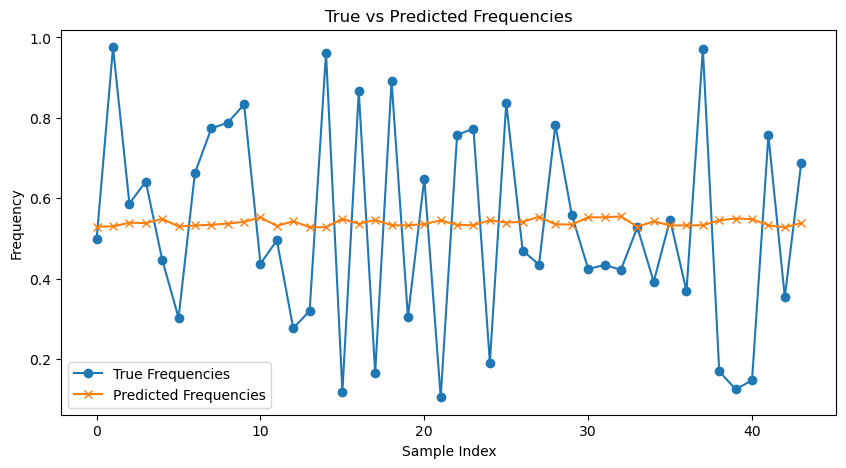

In [ ]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.numpy(), label="True Frequencies", marker='o')
plt.plot(y_pred_test.numpy(), label="Predicted Frequencies", marker='x')
plt.title("True vs Predicted Frequencies")
plt.xlabel("Sample Index")
plt.ylabel("Frequency")
plt.legend()
plt.show()

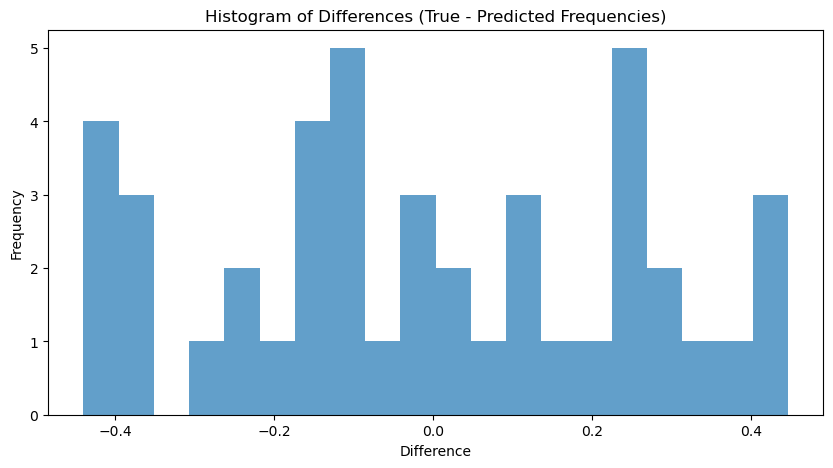

In [ ]:
diffs = y_test - y_pred_test
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(diffs.numpy(), bins=20, alpha=0.7)
plt.title("Histogram of Differences (True - Predicted Frequencies)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show() 

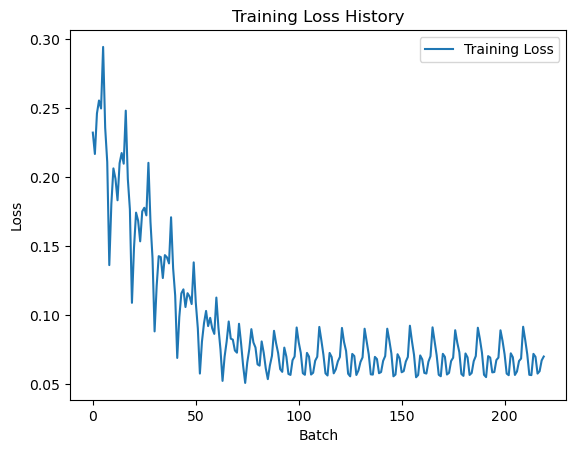

In [ ]:
plt.plot(loss_hist, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()


In [ ]:
params_hist[0].keys()

dict_keys(['positions', 'local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2', 'global_pulse_duration', 'local_pulse_duration', 'embed_pulse_duration', 'conv_params', 'out_fc_params'])

In [ ]:
positions_hist = np.array([i["positions"].detach().numpy() for i in params_hist])
local_pulses_omega_1_hist = np.array([i["local_pulses_omega_1"].detach().numpy() for i in params_hist])
local_pulses_delta_1_hist = np.array([i["local_pulses_delta

(221, 5, 2)

In [ ]:
params_hist_nice = {
    key: np.array([i[key].detach().numpy() for i in params_hist])
    for key in params_hist[0].keys()
}
print(params_hist_nice.keys())

dict_keys(['positions', 'local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2', 'global_pulse_duration', 'local_pulse_duration', 'embed_pulse_duration', 'conv_params', 'out_fc_params'])


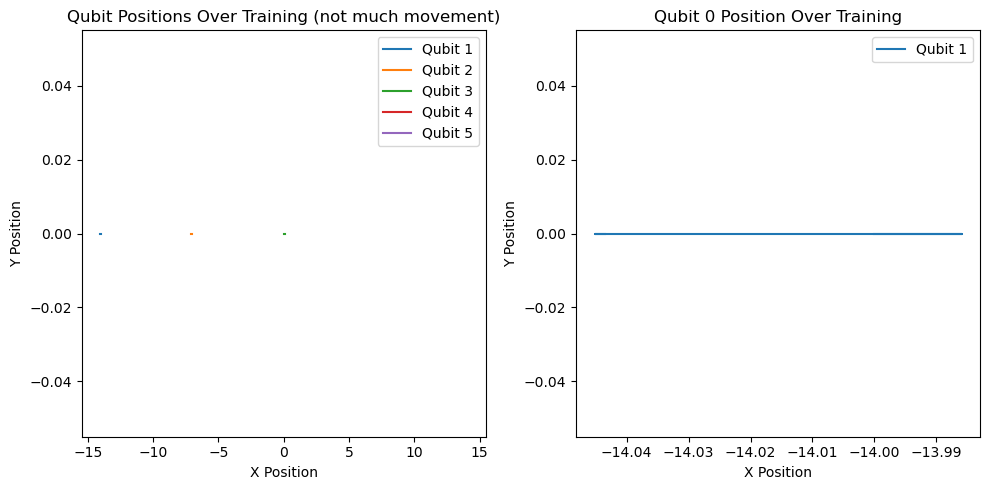

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
for qubit in range(positions_hist.shape[1]):
    plt.plot(positions_hist[:, qubit, 0], positions_hist[:, qubit, 1], label=f"Qubit {qubit+1}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training (not much movement)")
plt.legend()
plt.sca(axs[1])
# only first qubit
plt.plot(positions_hist[:, 0, 0], positions_hist[:, 0, 1], label="Qubit 1")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit 0 Position Over Training")
plt.legend()
plt.tight_layout()  
plt.show()  

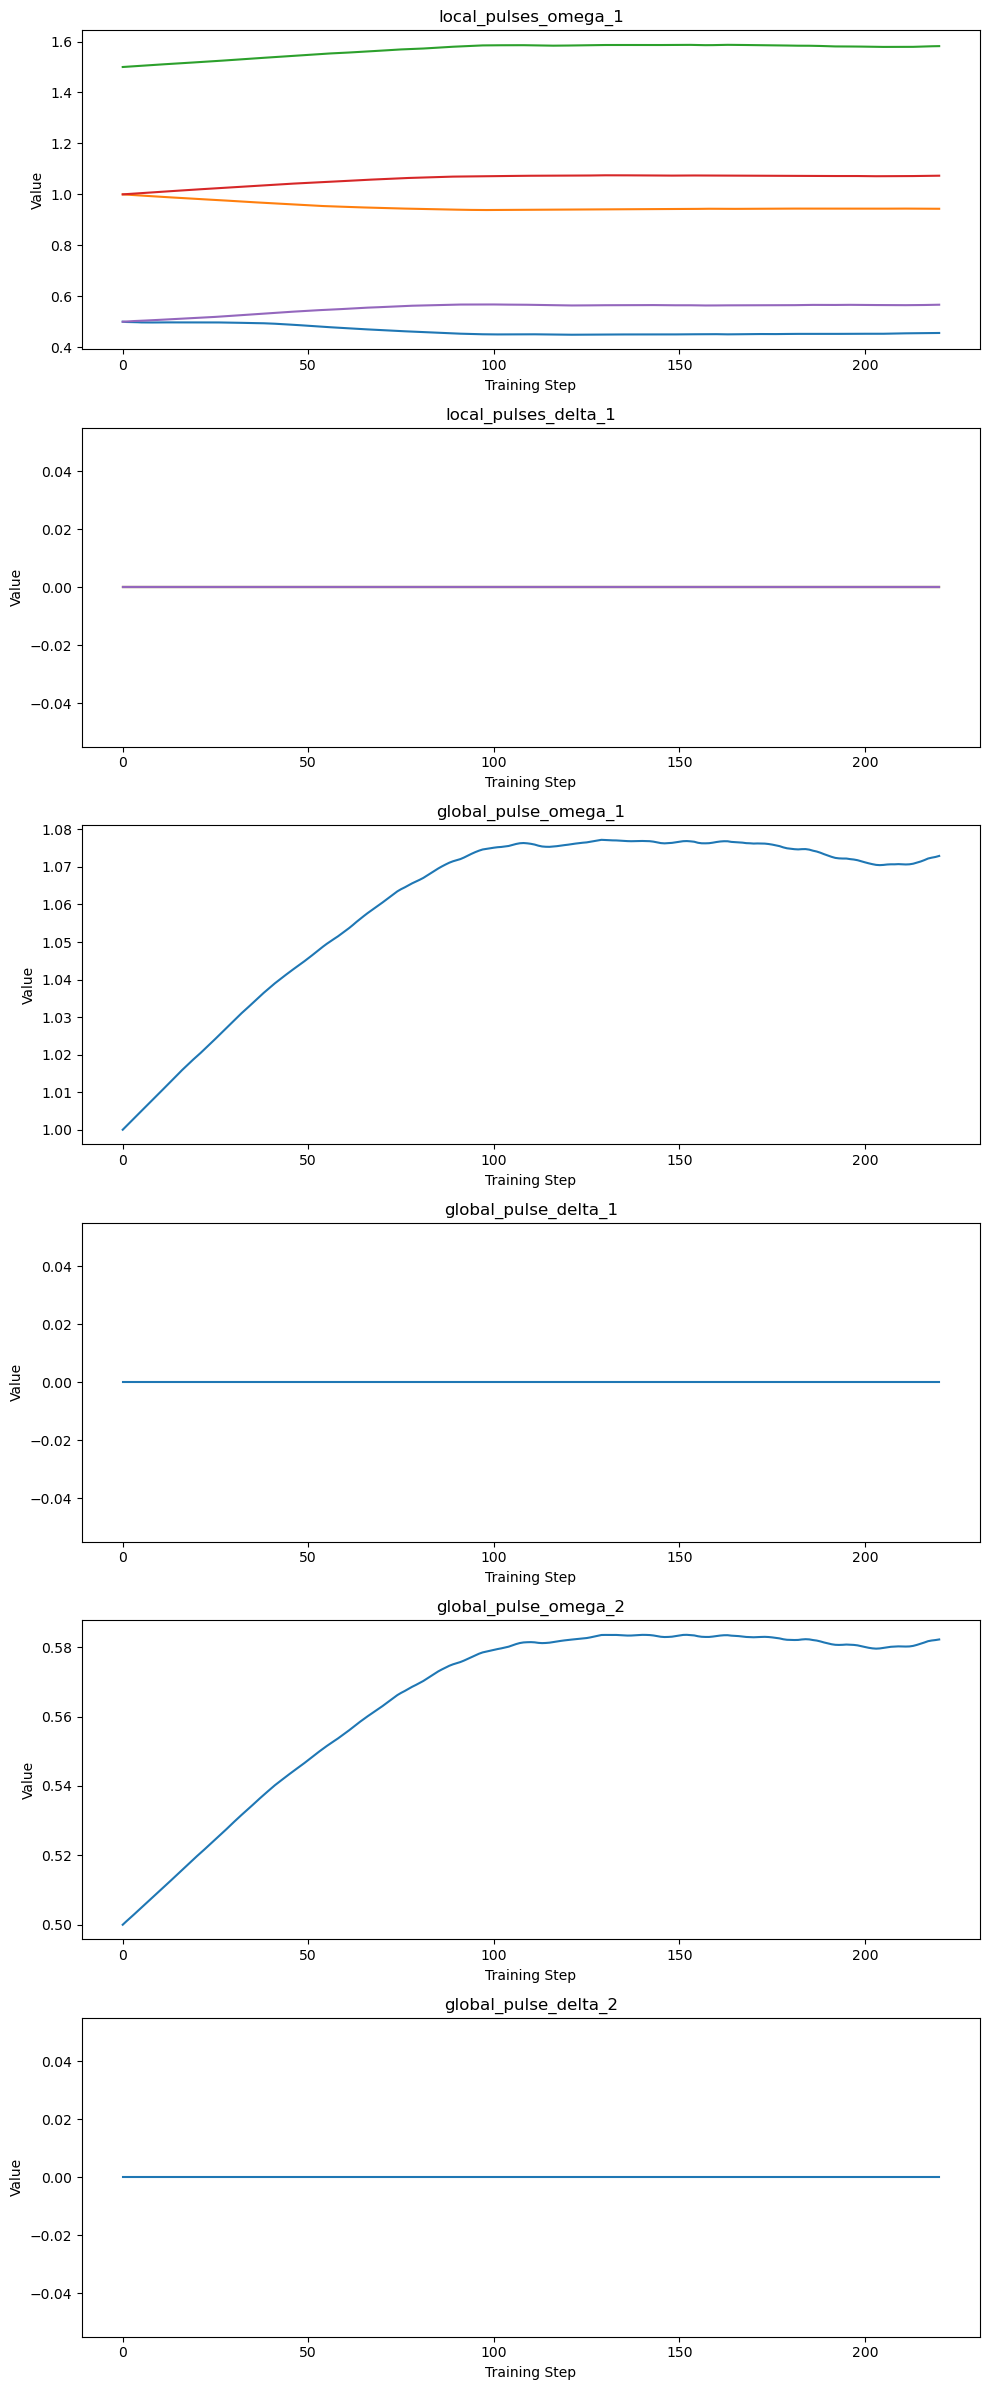

In [ ]:
plot_keys = ['local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2']
fig, axs = plt.subplots(len(plot_keys), 1, figsize=(10, 4 * len(plot_keys)))
for i, key in enumerate(plot_keys):
    axs[i].plot(params_hist_nice[key])
    axs[i].set_title(key)
    axs[i].set_xlabel("Training Step")
    axs[i].set_ylabel("Value")
plt.tight_layout()
plt.show()  

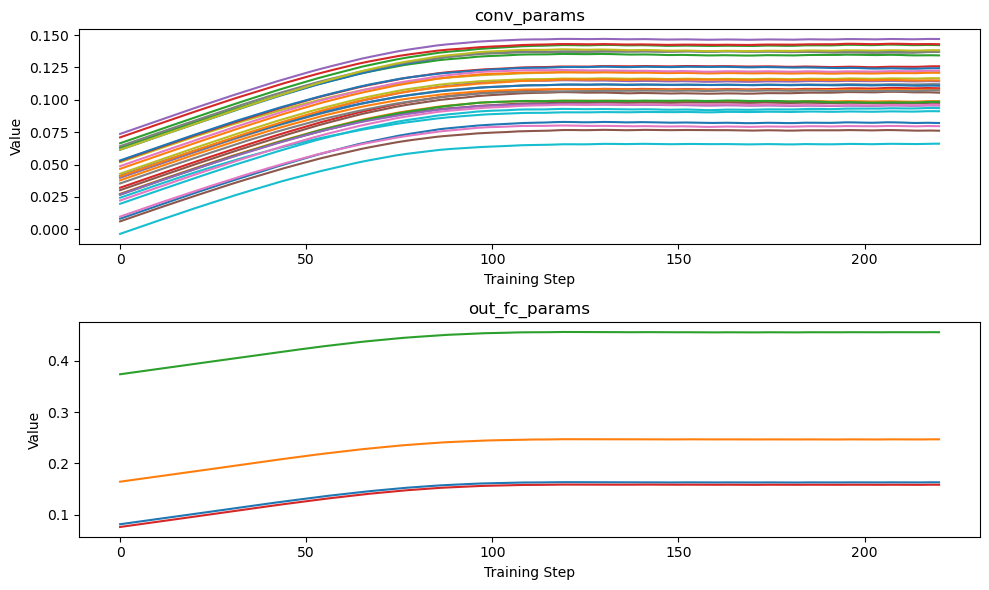

In [ ]:
plot_keys = ['conv_params', 'out_fc_params']
fig, axs = plt.subplots(len(plot_keys), 1, figsize=(10, 3 * len(plot_keys)))
for i, key in enumerate(plot_keys):
    axs[i].plot(params_hist_nice[key])
    axs[i].set_title(key)
    axs[i].set_xlabel("Training Step")
    axs[i].set_ylabel("Value")
plt.tight_layout()
plt.show()

In [ ]:
# look at kernel outputs
from source.NAHEA_CNN import state_to_output_learned

NAHEA_CNN.eval()
y_pred_test = []
i = 0
x_tmp = X_test[i]
x_tmp = torch.tensor(x_tmp, dtype=torch.float64).squeeze(1)
out_tmp = []
results_tmp = []
for pos in tqdm(range(0, seq_len - n_features + 1, NAHEA_CNN.hparams["stride"])):
    base_seq = NAHEA_CNN.setup_register()
    x_slice = x_tmp[pos : pos + n_features]
    seq_built = base_seq.build(x=x_slice)
    sim = TorchEmulator.from_sequence(seq_built, sampling_rate=0.2)

    with torch.no_grad():
        results = sim.run(
            time_grad=False, dist_grad=False, solver=SolverType.DP5_SE
        )
    output = state_to_output_learned(
        results.states[-1], NAHEA_CNN.classical_params["conv_params"]
    ).squeeze()
    out_tmp.append(output.item())
    results_tmp.append(results)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
print(f"{results.states[-1].abs()=}")
print(f"{NAHEA_CNN.classical_params['conv_params']=}")

results.states[-1].abs()=tensor([[0.0320],
        [0.0518],
        [0.0700],
        [0.0452],
        [0.1062],
        [0.1010],
        [0.1488],
        [0.0835],
        [0.0203],
        [0.1418],
        [0.2232],
        [0.3893],
        [0.1679],
        [0.0988],
        [0.3626],
        [0.0828],
        [0.0304],
        [0.1371],
        [0.2132],
        [0.1905],
        [0.0750],
        [0.3390],
        [0.0835],
        [0.1412],
        [0.0948],
        [0.1591],
        [0.3862],
        [0.2113],
        [0.1537],
        [0.0943],
        [0.1061],
        [0.1406]], dtype=torch.float64)
NAHEA_CNN.classical_params['conv_params']=tensor([0.0821, 0.0990, 0.1343, 0.1090, 0.1470, 0.0977, 0.0797, 0.1121, 0.1212,
        0.0912, 0.1378, 0.1210, 0.0985, 0.1259, 0.0956, 0.0762, 0.0961, 0.1370,
        0.1383, 0.0936, 0.1244, 0.1077, 0.1422, 0.1429, 0.1143, 0.1055, 0.1225,
        0.1073, 0.1167, 0.0661, 0.1109, 0.1150], dtype=torch.float64,
       requires_grad=True

In [ ]:
out_tmp

[0.5361542948326364,
 0.5036818919571344,
 0.5142985508551541,
 0.5286246643059338]